### Packages
Loading relevant packages

In [1]:
# required libraries
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# sentiment analysis to determine positive/negative titles and tags
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pickle

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alagat\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data & EDA
#### Data access

In [2]:
data_dir = './data/'

movies = pd.read_csv(data_dir+'movies.csv')
ratings = pd.read_csv(data_dir+'ratings.csv')
tags = pd.read_csv(data_dir+'tags.csv')

#### Data preparation and data clearning

In [3]:
# split the genres into individual values

def prepare_df(df):
    # split genres
    d_genre = df['genres'].str.split('|', expand=True)
    
    # extract the year from the title
    year = movies['title'].str[-7:] # get the year values
    year = [x.replace(')', '') for x in year] # remove closing brackets
    year = [x.replace('(', '') for x in year] # remove opening brackets
    year = [x.replace(' ', '') for x in year] # remove any spaces
    df['year'] = pd.Series([x if x.isdecimal() and len(x) == 4 else np.nan for x in year]) # remove no number 
    
    # combine the dataset columns
    df = pd.concat([df['movieId'], df['year'], df['title'], d_genre], axis=1)
    
    return(df)


def stringPositivity(s):
    sid = SentimentIntensityAnalyzer()
    
    x = [sid.polarity_scores(word)['compound'] for word in s.split()]
    
    # x = sum(x)/len(x)
    if(sum(1 for y in x if y != 0) == 0): x = 0
    else: x = sum(y for y in x if y != 0)/sum(1 for y in x if y != 0)
    
    return x

In [4]:
# datasets combined 

df = prepare_df(movies)
df = df.merge(ratings[['userId','movieId','rating']], on='movieId')
df = df.merge(tags[['userId','movieId','tag']], on=['movieId','userId'])

df.head()

,movieId,year,title,0,1,2,3,4,5,6,7,8,9,userId,rating,tag
0,1,1995,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,336,4.0,pixar
1,1,1995,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,474,4.0,pixar
2,1,1995,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,567,3.5,fun
3,2,1995,Jumanji (1995),Adventure,Children,Fantasy,None,None,None,None,None,None,None,62,4.0,fantasy
4,2,1995,Jumanji (1995),Adventure,Children,Fantasy,None,None,None,None,None,None,None,62,4.0,magic board game


In [5]:
# reshape to long then wide
idvars = ['movieId','userId','year','title','rating','tag']
df2 = pd.melt(df,id_vars=idvars,var_name='values', value_name='genre')
df2['values'] = 1

#  reshape back to wide
df3 = df2.pivot_table(index=idvars, columns='genre', values='values')

# convert pvot to dataframe
df3 = pd.DataFrame(df3.to_records()) 

# fill missing values in the genres
allVars = list(df3.columns)
df3[list(set(allVars) - set(idvars))] = df3[list(set(allVars) - set(idvars))].fillna(0)

# add sentiment positivity for the title and tags, and length of the title

df3['title_length'] = df3['title'].str.len()
df3['title'] = df3['title'].apply(lambda x: stringPositivity(x))
df3['tag'] = df3['tag'].apply(lambda x: stringPositivity(x))

df3.head()

,movieId,userId,year,title,rating,tag,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_length
0,1,336,1995,0.0,4.0,0.0000,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,1,474,1995,0.0,4.0,0.0000,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
2,1,567,1995,0.0,3.5,0.5106,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
3,2,62,1995,0.0,4.0,0.0000,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
4,2,62,1995,0.0,4.0,0.0000,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14


In [6]:
df3.tail()

,movieId,userId,year,title,rating,tag,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_length
3468,187595,62,2018,-0.5574,4.0,-0.5574,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30
3469,193565,184,2010,0.0000,3.5,0.0000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25
3470,193565,184,2010,0.0000,3.5,0.3612,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25
3471,193565,184,2010,0.0000,3.5,0.0000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25
3472,193565,184,2010,0.0000,3.5,0.0000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25


<AxesSubplot:ylabel='Frequency'>

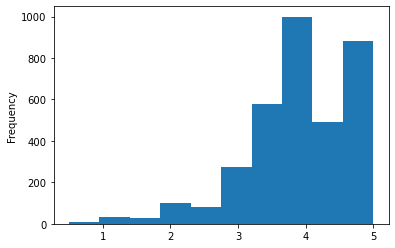

In [7]:
# distribution of label variable

df3['rating'].plot(kind="hist")

In [8]:
# correlation of variables

df3.drop(columns=['rating', 'movieId', 'userId']).corr().style.background_gradient(cmap='rainbow')

,title,tag,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_length
title,1.000000,0.048342,-0.132819,-0.032210,-0.021317,0.007317,0.103735,-0.111370,-0.010055,0.090002,-0.031148,-0.029772,-0.077517,-0.019434,-0.005143,-0.057242,0.171280,-0.022408,-0.128161,0.016020,-0.045510,0.004822
tag,0.048342,1.000000,0.004927,0.072625,0.072146,0.068331,0.114602,-0.010810,-0.017736,-0.062633,0.050729,-0.049489,-0.046222,0.014018,0.006751,-0.024728,0.029140,0.027949,-0.058859,-0.037451,0.006253,0.005973
Action,-0.132819,0.004927,1.000000,0.322028,-0.003897,-0.063147,-0.232796,0.100951,-0.091828,-0.232014,0.017061,-0.054440,-0.004107,0.230240,-0.082100,-0.067729,-0.166669,0.394406,0.130249,0.034457,0.035183,0.100651
Adventure,-0.032210,0.072625,0.322028,1.000000,0.186530,0.287550,-0.119462,-0.174737,-0.071375,-0.260752,0.255235,-0.043265,-0.097328,0.235634,-0.023956,-0.139542,-0.101003,0.336995,-0.183027,-0.062509,-0.029155,0.144349
Animation,-0.021317,0.072146,-0.003897,0.186530,1.000000,0.412881,0.070715,-0.135228,-0.045246,-0.093588,0.292189,-0.029887,-0.043251,0.016324,0.193532,-0.083660,-0.042949,0.018959,-0.152459,-0.006625,-0.035091,0.068290
Children,0.007317,0.068331,-0.063147,0.287550,0.412881,1.000000,0.076854,-0.114464,-0.039977,-0.131390,0.334880,-0.026407,-0.059680,-0.006358,0.141680,-0.067276,-0.061381,-0.062374,-0.151256,-0.050630,-0.031004,0.046051
Comedy,0.103735,0.114602,-0.232796,-0.119462,0.070715,0.076854,1.000000,0.120264,-0.104535,-0.190556,0.060917,-0.076485,-0.115669,-0.137077,0.098590,-0.179461,0.194699,-0.251690,-0.140571,-0.059284,-0.051531,-0.071151
Crime,-0.111370,-0.010810,0.100951,-0.174737,-0.135228,-0.114464,0.120264,1.000000,-0.091150,0.137436,-0.137456,0.077126,-0.066409,0.013180,-0.085101,0.083204,-0.199597,-0.168642,0.413361,-0.085164,-0.065349,-0.078345
Documentary,-0.010055,-0.017736,-0.091828,-0.071375,-0.045246,-0.039977,-0.104535,-0.091150,1.000000,-0.183371,-0.050487,-0.018979,-0.042893,-0.019180,-0.021964,-0.060114,-0.076289,-0.080643,-0.112728,-0.010842,-0.022283,0.029940
Drama,0.090002,-0.062633,-0.232014,-0.260752,-0.093588,-0.131390,-0.190556,0.137436,-0.183371,1.000000,-0.144753,-0.019823,-0.074370,-0.098346,-0.085174,0.023233,0.035984,-0.214958,0.133552,0.124611,-0.013419,-0.039734


In [9]:
# Split data into train, validation and test sets

x_train, df_full_test = train_test_split(df3, test_size=0.4, random_state=1, stratify=df3.rating)
x_test, x_val = train_test_split(df_full_test, test_size=0.5, random_state=1)

y_train = x_train.rating.values
y_val = x_val.rating.values
y_test = x_test.rating.values

x_train = x_train.drop(columns=['rating', 'movieId', 'userId'])
x_val = x_val.drop(columns=['rating', 'movieId', 'userId'])
x_test = x_test.drop(columns=['rating', 'movieId', 'userId'])

### feature importance analysis

<AxesSubplot:>

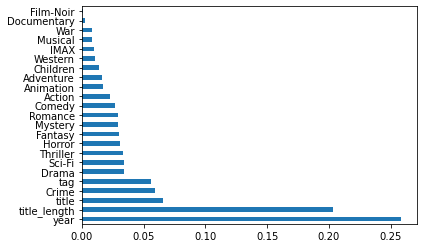

In [10]:
# decision tree model

dtr = RandomForestRegressor()# DecisionTreeRegressor()
dtr.fit(x_train,y_train)

feat_importances = pd.Series(dtr.feature_importances_, index=x_train.columns)
feat_importances.nlargest(len(x_train.columns)).plot(kind='barh')

# print(dtr.score(x_val,y_val))

### Model selection and parameter tuning

In [11]:
# combine all data
y_full_train = np.concatenate([y_train, y_val])
x_full_train = pd.concat([x_train, x_val])

In [12]:
# Decsion tree model

param_grid = {
    "max_depth":np.linspace(1, 100, 100, endpoint=True)
}

dt_reg = DecisionTreeRegressor()

dt_reg_tuned = GridSearchCV(estimator=dt_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

dt_reg_tuned.fit(x_train, y_train)
dt_reg_tuned.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


DecisionTreeRegressor(max_depth=9.0)

In [13]:
dt_model = DecisionTreeRegressor(max_depth=7.0)
dt_model.fit(x_full_train, y_full_train)

y = dt_model.predict(x_test)
mean_squared_error(y, y_test)

0.5304235588709592

In [14]:
# Fine tune random forest model

param_grid = {
    "n_estimators":[1, 10, 30, 50, 70, 100,200,300],
    "max_depth":[1, 10, 50, 100, 200,500, 1000],
    "max_features":[1,2,3,4,5,6,8,10]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(x_train, y_train)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 448 candidates, totalling 1344 fits


RandomForestRegressor(max_depth=500, max_features=6, n_estimators=300)

In [15]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=500, max_features=5 )
rf_model.fit(x_full_train, y_full_train)

y = rf_model.predict(x_test)
mean_squared_error(y, y_test)

0.3363377724805138

### Export model

In [16]:
output_file = f'rf_model.bin'

with open(output_file, 'wb') as outfile:
    pickle.dump(rf_model, outfile)

### loading and using the model

In [17]:
import pickle

input_file = 'rf_model.bin'

with open(input_file, 'rb') as f_input:
    model = pickle.load(f_input)